In [1]:
# Importing libraries and setting pandas to not display anything in scientific notation.

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


pd.set_option('display.float_format', '{:.2f}'.format)
fig_path = '../figures/'

In [2]:
# Importing csv file into pandas, converting one column to a to_timedelta

df = pd.read_csv('../data/ultra_marathons_data_cleaned.csv')

df['fastest_time'] = pd.to_timedelta(df['fastest_time'], errors='coerce')
df.head()

C:\Users\OMEN\AppData\Local\Temp\ipykernel_18824\2378424342.py:3: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/ultra_marathons_data_cleaned.csv')


,year_of_event,event_name,distance_or_length,no_of_finishers,total_distance,athlete_club,athlete_country,birth_year,gender,age_category,average_speed,athlete_id,race_metric,start_date,end_date,fastest_time
0,2018,Selva Costera (CHI),50.00,22,0.00,Tnfrc,CHI,1978,M,M35,10.286,0,km,2018-01-06,2018-01-06,0 days 04:51:39
1,2018,Selva Costera (CHI),50.00,22,0.00,Roberto Echeverría,CHI,1981,M,M35,9.501,1,km,2018-01-06,2018-01-06,0 days 05:15:45
2,2018,Selva Costera (CHI),50.00,22,0.00,Puro Trail Osorno,CHI,1987,M,M23,9.472,2,km,2018-01-06,2018-01-06,0 days 05:16:44
3,2018,Selva Costera (CHI),50.00,22,0.00,Columbia,ARG,1976,M,M40,8.976,3,km,2018-01-06,2018-01-06,0 days 05:34:13
4,2018,Selva Costera (CHI),50.00,22,0.00,Baguales Trail,CHI,1992,M,M23,8.469,4,km,2018-01-06,2018-01-06,0 days 05:54:14


In [3]:
# Checking to see how many null values are in the dataset. Some values are not fixable unfortunately, at least not with this data.

df.isnull().sum()

year_of_event            0
event_name               0
distance_or_length    1436
no_of_finishers          0
total_distance           2
athlete_club            42
athlete_country          3
birth_year               0
gender                   7
age_category             0
average_speed          224
athlete_id               0
race_metric           1436
start_date               0
end_date                19
fastest_time           189
dtype: int64

In [5]:
df['race_metric'].value_counts()

race_metric
mi       6933103
hours     526656
Name: count, dtype: int64

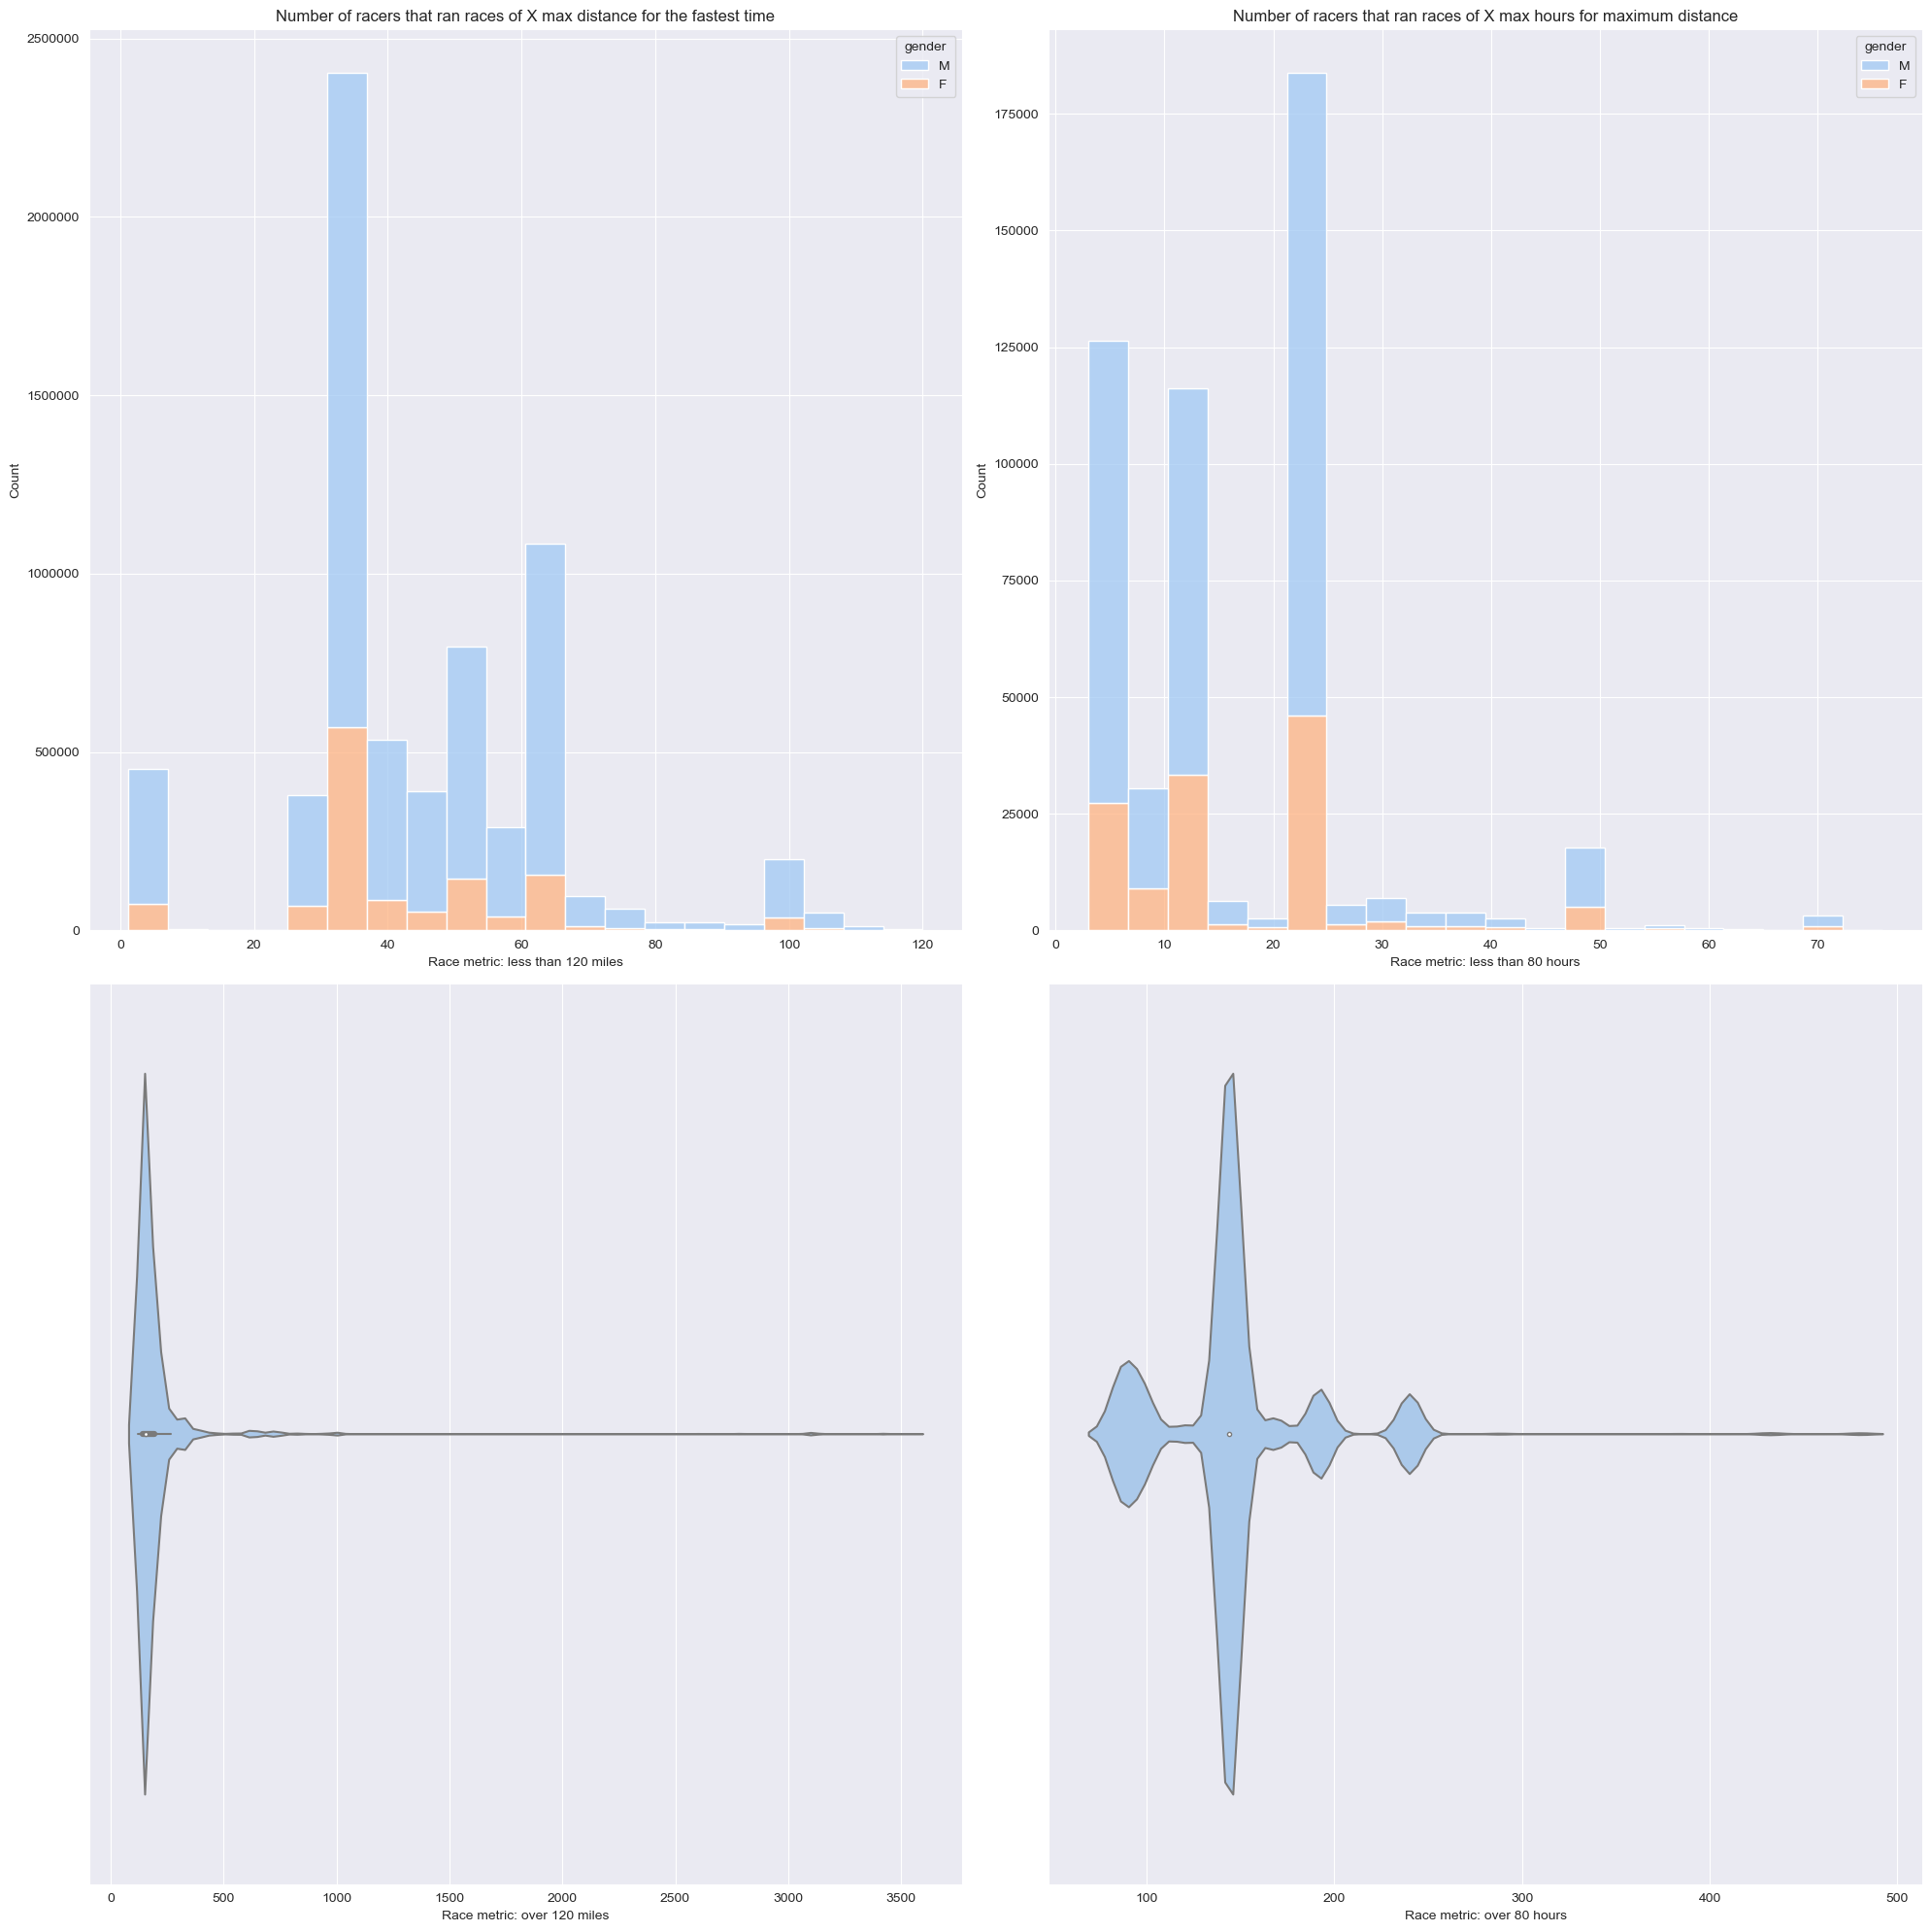

In [6]:
'''
For this visualization I spent quite a while figuring out how to get this to work, as there were a lot of weird technical
problems with the data and binning process going into seaborn, but eventually I figured it out.

I decided to separate out the top 20%ish of the data as it was completely throwing off the entire figure to where
there would be one column that went to the top of the figure and you could barely see the others. Some of these races are a bit
over 3000 miles, but that vast majority are within less than 5% of that. The top two figures show that vast majority and their distribution
in bins.

The data shows that mostly men participate in these races and that participation falls off at around the 24 hour or 70 mile mark.
'''

sns.set_palette('pastel')
sns.set_style('darkgrid')

hours_hist_data = df[
    (df['race_metric'] == 'hours') & 
    (df['distance_or_length'] > 1) &
    (df['gender'].isin(['M', 'F'])) & 
    (df['distance_or_length'].notnull())
].copy()

times_hist_data = df[
    (df['race_metric'] == 'mi') & 
    (df['distance_or_length'] > 1) & 
    (df['gender'].isin(['M', 'F'])) & 
    (df['distance_or_length'].notnull())
].copy()

fig, ax = plt.subplots(2, 2, figsize=(20, 20))
sns.histplot(
    data=times_hist_data[times_hist_data['distance_or_length'] <= 120],
    x='distance_or_length',
    hue='gender',
    multiple = 'stack',
    bins = 20,
    ax=ax[0, 0]
)

sns.histplot(
    data=hours_hist_data[hours_hist_data['distance_or_length'] <= 80],
    x='distance_or_length',
    hue='gender',
    multiple= 'stack',
    bins = 20,
    ax=ax[0, 1]
)

sns.violinplot(
    data=times_hist_data[times_hist_data['distance_or_length'] > 120],
    x='distance_or_length',
    hue='gender',
    ax=ax[1, 0]
)

sns.violinplot(
    data=hours_hist_data[hours_hist_data['distance_or_length'] > 80],
    x='distance_or_length',
    hue='gender',
    ax=ax[1, 1]
)

ax[0, 0].set_title('Number of racers that ran races of X max distance for the fastest time')
ax[0, 0].set_xlabel('Race metric: less than 120 miles')
ax[0, 1].set_title('Number of racers that ran races of X max hours for maximum distance')
ax[0, 1].set_xlabel('Race metric: less than 80 hours')
ax[1, 0].set_xlabel('Race metric: over 120 miles')
ax[1, 1].set_xlabel('Race metric: over 80 hours')

ax[0, 0].ticklabel_format(style = 'plain', axis = 'y')
plt.tight_layout()

fig.savefig(f'{fig_path}count_of_runners_by_distance.jpg')

In [7]:
'''
Here I wanted to create a heat map showing where the most ultra runners come from.
Using the 3 letter code for country and taking the amount of times it appears in 
appears in the dataset, which is to say it shows how many times a person from a certain country signed
up for an ultra marathon and participated in it as well.

I was not suprised to see that the US was high up on this list, as there are a very large amount of
ultra marathons, I would also think that the vast majority of them occur here in the US. I was a little bit
surprised to see that France and Japan were 2nd and 3rd, where France was quite close to the US, which
surprised me seeing as how it is much smaller than the US. 

Outside of that countries that are having the most sign ups are countries surrounding France, Canada, China and Australia.
'''

country_counts = df['athlete_country'].value_counts().reset_index()

def format_hover_text(val):
    if val >= 1e6:
        return f'{val / 1e6:.1f} M'
    elif val >= 1e3:
        return f'{val / 1e3:.1f} K'
    else:
        return f'{val}'

country_counts['formatted_vals'] = country_counts['count'].apply(
    format_hover_text)

fig = px.choropleth(
    country_counts,
    locations='athlete_country',
    color='count',
    hover_name='athlete_country',
    hover_data={
        'count': False,
        'formatted_vals': True,
        'athlete_country': False
    },
    color_continuous_scale=px.colors.sequential.Plasma
)
for trace in fig.data:
    trace.hovertemplate = '%{customdata[2]}: %{customdata[1]}<extra></extra>'
fig.write_image(f'{fig_path}athletes_per_county.jpg')
fig.show()

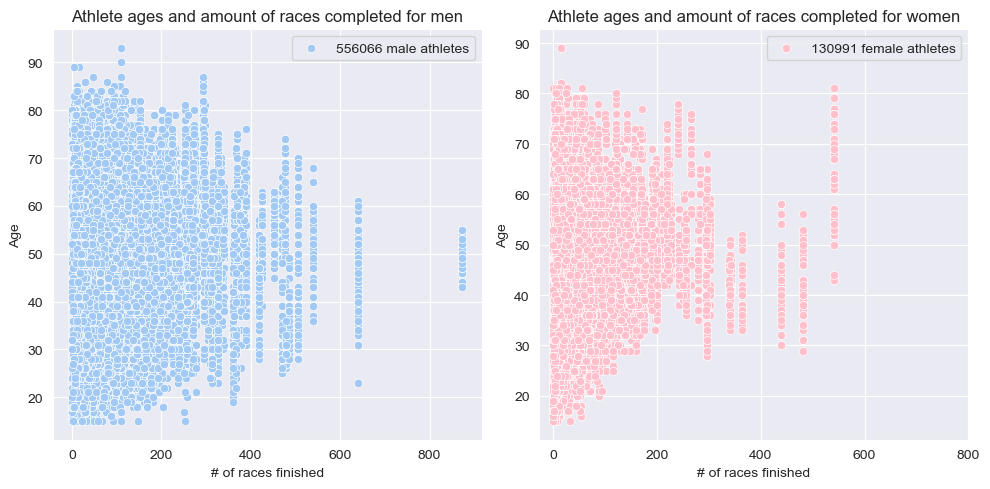

In [8]:
'''
Creating a new dataframe to be used with a scatter plot showing the age distribution
over gender and race participation.

In the data there seems to be some bad values in terms of age, such as negative values, values over 100,
so I filtered out values under 15 and over 95. Although ultra marathons are extremely intense, children 
have participated in them in the past. I once did a race where this kid who was somewhere between
12 and 16 years old or so, he ran 100 miles in that race, so I did want to include some of those lower values.
'''

athlete_races = df[['athlete_id', 'gender',
                    'year_of_event', 'birth_year']].copy()
athlete_races['gender'] = athlete_races['gender'].astype('category')
athlete_races['race_age'] = athlete_races['year_of_event'] - \
    athlete_races['birth_year']
race_counts = athlete_races['athlete_id'].value_counts()
athlete_races['race_count'] = athlete_races['athlete_id'].map(race_counts)
athlete_races.drop(columns=['year_of_event', 'birth_year'], inplace=True)
proper_ages = athlete_races[(athlete_races['race_age'] < 95) & (
    athlete_races['race_age'] > 14)].copy().reset_index()
custom_ticks = [0, 200, 400, 600, 800]


fig, ax = plt.subplots(1, 2, figsize=(10, 5))

bin_m = proper_ages[proper_ages['gender'] == 'M'].sample(frac=0.1)
bin_f = proper_ages[proper_ages['gender'] == 'F'].sample(frac=0.1)

sns.scatterplot(data=bin_m, x='race_count', y='race_age', ax=ax[0])
ax[0].set_title(f'Athlete ages and amount of races completed for men')
ax[0].set_xlabel('# of races finished')
ax[0].set_ylabel('Age')
ax[0].set_xticks(ticks=custom_ticks, labels=custom_ticks)
ax[0].legend([f'{len(bin_m)} male athletes'])

sns.scatterplot(data=bin_f[bin_f['race_count'] < 1000],
                x='race_count', y='race_age', color='pink', ax=ax[1])
ax[1].set_title(f'Athlete ages and amount of races completed for women')
ax[1].set_xlabel('# of races finished')
ax[1].set_ylabel('Age')
ax[1].set_xticks(ticks=custom_ticks, labels=custom_ticks)
ax[1].legend([f'{len(bin_f)} female athletes'])
plt.tight_layout()
fig.savefig(f'{fig_path}athlete_ages_and_number_of_races_completed.jpg')

In [9]:
# Creating dataframes, one with the data for only the winners of races that are timed by a fixed distance,
# and the other being the winners of races that have a fixed time frame where you can run for as much
# distance as you can in that time frame.

winners_time = df[
    (df['fastest_time'] > pd.to_timedelta(0, unit='hours')) &
    (df['race_metric'] == 'mi')
].sort_values(by='fastest_time', ascending=True).drop_duplicates(subset='event_name')

winners_distance = df[
    (df['distance_or_length'] > 0) &
    (df['race_metric'] == 'hours')
].sort_values(by='distance_or_length', ascending=False).drop_duplicates(subset='event_name')

winners_distance.head()

,year_of_event,event_name,distance_or_length,no_of_finishers,total_distance,athlete_club,athlete_country,birth_year,gender,age_category,average_speed,athlete_id,race_metric,start_date,end_date,fastest_time
2476993,2019,Running Festival Wychwood December 20 Days (RSA),480.00,15,1004.50,Unknown,USA,1938,M,M80,2.093,76752,hours,2019-12-12,2020-01-01,0 days
7121236,1987,"Sri Chinmoy Ultra Trio 1300,1000,700 Mile Race...",432.00,24,912.50,"Ozone Park,NY",USA,1949,M,M35,2112.00,1312053,hours,1987-06-05,1987-06-23,0 days
7167145,1988,Sri Chinmoy Ultra Trio 1300 Mile Race (USA),432.00,2,1886.15,Kleinostheim,GER,1962,M,M23,4366.00,391606,hours,1988-05-20,1988-06-07,0 days
1643202,2017,Ultimate Circuits South Africa 16 Day Challeng...,384.00,5,1001.01,"Cleveland, OH",USA,1948,M,M65,2.607,34750,hours,2017-07-22,2017-08-07,0 days
3769586,1999,12 Days Race Latvia (LAT),288.00,12,216.00,LSC-Ann.,LAT,1939,F,W55,0.75,1097874,hours,1999-09-20,1999-10-02,0 days


In [10]:
# Checking to see the shape of the data, there are about 26000 different races in the dataset so everything looks good here.

winners_time.shape, winners_distance.shape

((21084, 16), (5829, 16))

In [11]:
# Create new dataframes from the previously sorted ones, separating them by gender and finding the athletes
# that have the most 1st place victories.

winner_time_M = winners_time[winners_time['gender']
                             == 'M']['athlete_id'].value_counts()
winner_time_F = winners_time[winners_time['gender']
                             == 'F']['athlete_id'].value_counts()

winner_distance_M = winners_distance[winners_distance['gender']
                                     == 'M']['athlete_id'].value_counts()
winner_distance_F = winners_distance[winners_distance['gender']
                                     == 'F']['athlete_id'].value_counts()

winner_time_M

athlete_id
24893      166
36441       66
475391      53
43644       48
4625        47
          ... 
1222152      1
273295       1
1253035      1
1223528      1
255909       1
Name: count, Length: 11840, dtype: int64

In [12]:
# Merging the dataframes for distance and time races on athlete id so that the total amount
# of races won by a certain athlete can be seen.

merge_men = pd.merge(winner_distance_M, winner_time_M,
                     on='athlete_id', how='outer', suffixes=('_1', '_2'))
merge_women = pd.merge(winner_distance_F, winner_time_F,
                       on='athlete_id', how='outer', suffixes=('_1', '_2'))

merge_men.fillna(0, inplace=True)
merge_women.fillna(0, inplace=True)

merge_men['total_count'] = merge_men['count_1'] + merge_men['count_2']
merge_women['total_count'] = merge_women['count_1'] + merge_women['count_2']

merge_men.drop(['count_1', 'count_2'], inplace=True, axis=1)
merge_women.drop(['count_1', 'count_2'], inplace=True, axis=1)

merge_men.sort_values(by='total_count', ascending=False, inplace=True)
merge_women.sort_values(by='total_count', ascending=False, inplace=True)

merge_men = merge_men.reset_index()
merge_women = merge_women.reset_index()

merge_men.head()

,athlete_id,total_count
0,24893,166.00
1,36441,66.00
2,475391,53.00
3,43644,49.00
4,4625,47.00


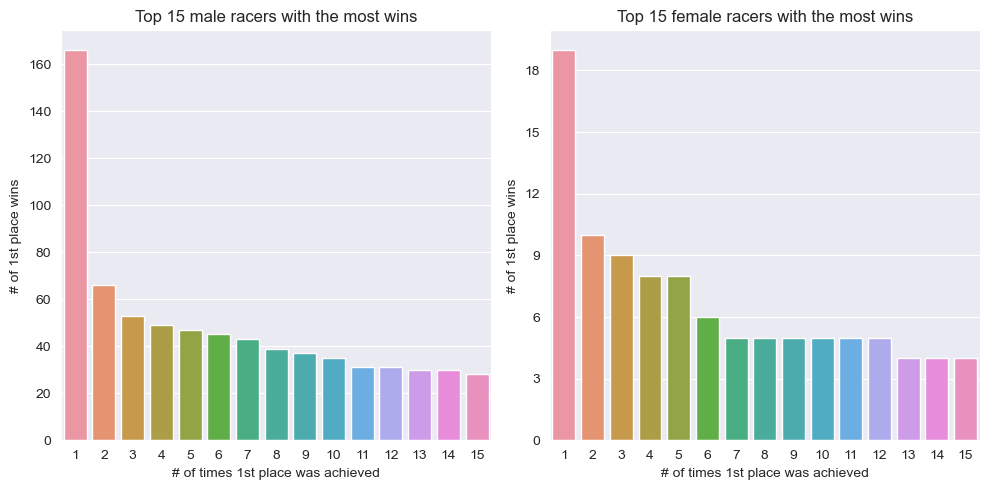

In [13]:
# Creating a figure showing the top 15 athletes that have won the most races in their gender

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
x = np.arange(1, 16, 1)
sns.barplot(data=merge_men.head(15), x=x, y='total_count', ax=ax[0])
sns.barplot(data=merge_women.head(15), x=x, y='total_count', ax=ax[1])
ax[0].set_title('Top 15 male racers with the most wins')
ax[0].set_xlabel('# of times 1st place was achieved')
ax[0].set_ylabel('# of 1st place wins')
ax[1].set_title('Top 15 female racers with the most wins')
ax[1].set_xlabel('# of times 1st place was achieved')
ax[1].set_ylabel('# of 1st place wins')
ax[1].set_yticks(np.arange(0, 19, 3))
plt.tight_layout()

In [14]:
# Checking to see how many values have invalid values for total distance and how many are valid

((df['race_metric'] == 'hours') & (df['total_distance'] == 0)).sum(
), ((df['race_metric'] == 'hours') & (df['total_distance'] > 0)).sum()

(81, 526575)

In [15]:
'''
Counting the amount of overall winners there are for each gender and race format (time and distance), overall winners being the person that got
1st place out of all men AND women. While it is pretty rare, sometimes the women to beat out all the men and
women in a race. A shining example of this would be the legendary Courtney Dauwalter, a ultra runner that still
holds the course record at one of the most popular ultra marathons in the world, the 240 mile race, Moab 240 in Utah, USA.
'''

winners_overall_by_hours = df[
    (df['race_metric'] == 'hours') &
    (df['distance_or_length'] > 0)
].sort_values(by='total_distance', ascending=False).drop_duplicates(subset='event_name')
male_victors_hours = (winners_overall_by_hours['gender'] == 'M').sum()
female_victors_hours = (winners_overall_by_hours['gender'] == 'F').sum()

winners_overall_by_time = df[
    (df['race_metric'] == 'mi') &
    (df['fastest_time'] > pd.to_timedelta(0, unit='m'))
].sort_values(by='fastest_time', ascending=True).drop_duplicates(subset='event_name')
male_victors_time = (winners_overall_by_time['gender'] == 'M').sum()
female_victors_time = (winners_overall_by_time['gender'] == 'F').sum()

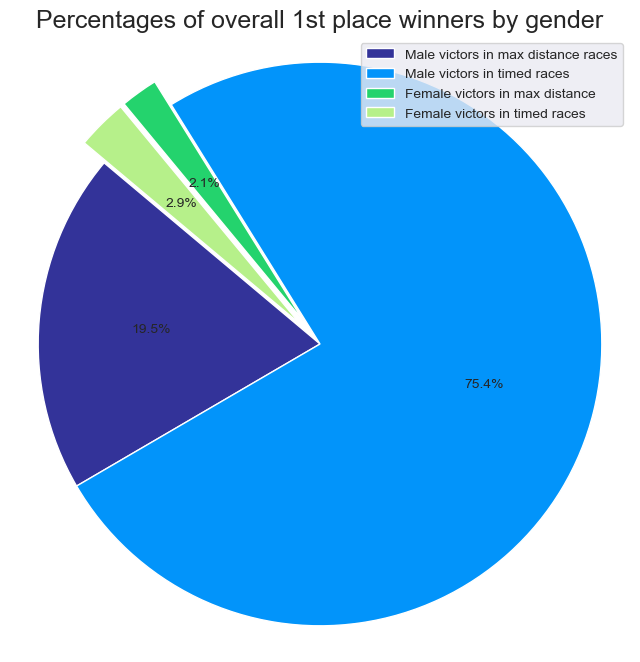

In [16]:
# Showing the percentage of overall victors for each gender and race format

total_victors = male_victors_hours + female_victors_hours + \
    male_victors_time + female_victors_time
labels = ['Male victors in max distance races', 'Male victors in timed races',
          'Female victors in max distance ', 'Female victors in timed races']
sizes = [
    (male_victors_hours / total_victors) * 100,
    (male_victors_time / total_victors) * 100,
    (female_victors_hours / total_victors) * 100,
    (female_victors_time / total_victors) * 100
]
explode = [0, 0, 0.1, 0.1]
cmap = plt.get_cmap('terrain', 8)
colors = [cmap(i) for i in range(0, 4)]

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, autopct='%1.1f%%',
        startangle=140, colors=colors)
plt.axis('equal')
plt.title('Percentages of overall 1st place winners by gender', fontsize=18)
plt.legend(labels, loc='upper right')
plt.savefig(f'{fig_path}overall_victors_by_gender.jpg')
plt.show()